In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt

# 1. Capacitive Coupling

In [169]:
# simulate a resonator, qubit, and coupler system

# frequencies
omega_q = 0 * 2 * np.pi # 2pi GHz
omega_c = 1 * 2 * np.pi # 2pi GHz
omega_r = 2 * 2 * np.pi # 2pi GHz

# interaction
U = -0.1 * 2 * np.pi # 2pi GHz

# coupling
g_qc = 0.1 * 2 * np.pi # 2pi GHz
g_qc = 0.1 * 2 * np.pi # 2pi GHz
g_qr = 0.1 * 2 * np.pi # 2pi GHz

chi = g_qr**2/(omega_r - omega_q)


# decay terms
kappa = 0.002 * 2 * np.pi # 2pi GHz
gamma_1 = 0.0002 * 2 * np.pi # 2pi GHz
gamma_phi = 2 * gamma_1

# resonator drive amplitude
eta = np.sqrt(kappa/2)


In [170]:
# define operators (assume TLS)
num_levels_r = 10
num_levels_q = 2
num_levels_c = 2

id_r = qt.qeye(num_levels_r)
id_q = qt.qeye(num_levels_q)
id_c = qt.qeye(num_levels_c)
identity = qt.qeye([num_levels_r, num_levels_q, num_levels_c])

a_r = qt.tensor(qt.destroy(num_levels_r), id_q, id_c)
a_q = qt.tensor(id_r, qt.destroy(num_levels_q), id_c)
a_c = qt.tensor(id_r, id_q, qt.destroy(num_levels_c))

sigmaz_q = 2*a_q.dag()*a_q - identity
sigmaz_c = 2*a_c.dag()*a_c - identity

In [171]:
def drive_coeff(t, args):
    omega_r = args['omega_r']
    
    return np.exp(-1j * omega_r * t)
    

In [172]:
# define Hamiltonian

H_r = omega_r*a_r.dag()*a_r
H_q = omega_q*a_q.dag()*a_q - U/2*a_q.dag()*a_q*(a_q.dag()*a_q - identity)
H_c = omega_c*a_c.dag()*a_c - U/2*a_c.dag()*a_c*(a_c.dag()*a_c - identity)

# H_qr = chi*a_r.dag()*a_r*(2*a_q.dag()*a_q - identity)
H_qr = g_qr*(a_q.dag()*a_r + a_r.dag()*a_q)
H_qc = g_qc*(a_q.dag()*a_c + a_c.dag()*a_q)

H = [H_r + H_q + H_c + H_qr + H_qc, [eta*(a_r + a_r.dag()), drive_coeff]]

In [179]:
psi0 = qt.basis([num_levels_r, num_levels_q, num_levels_c], [0, 1, 0])

times = np.linspace(0, 10, 1001)
args={'omega_r': omega_r - chi}


c_ops = [kappa*a_r, gamma_1 * (a_q + a_c), gamma_phi*(sigmaz_q + sigmaz_c)]

result = qt.mesolve(H, psi0, times, e_ops=[a_r.dag()*a_r, a_q.dag()*a_q, a_c.dag()*a_c, a_r], args=args, c_ops=c_ops)

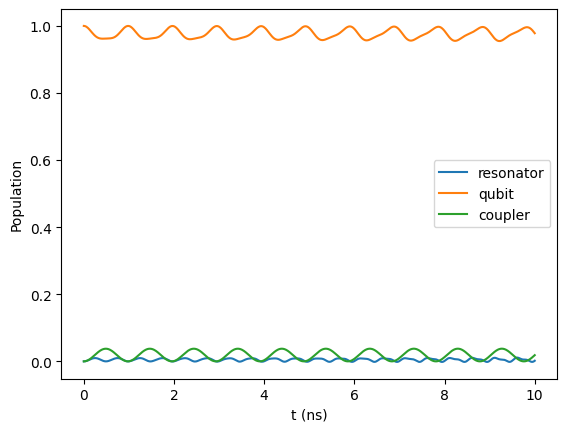

In [180]:
plt.plot(times, result.expect[0], label='resonator')

plt.plot(times, result.expect[1], label='qubit')
plt.plot(times, result.expect[2], label='coupler')

plt.xlabel('t (ns)')
plt.ylabel('Population')

plt.legend()
plt.show()

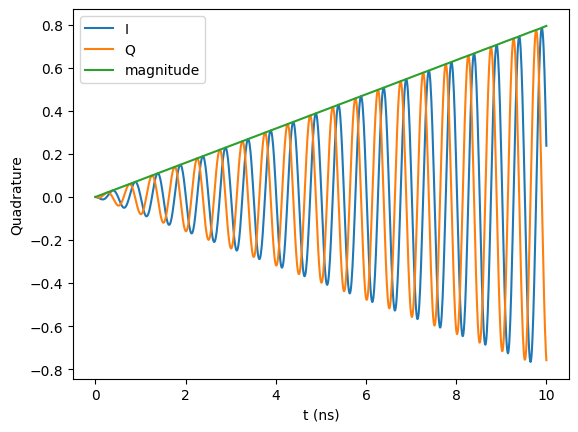

In [181]:
plt.plot(times, np.real(result.expect[-1]), label='I')
plt.plot(times, np.imag(result.expect[-1]), label='Q')
plt.plot(times, np.abs(result.expect[-1]), label='magnitude')

plt.xlabel('t (ns)')
plt.ylabel('Quadrature')

plt.legend()
plt.show()